In [ ]:
import pandas as pd
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
seed_everything(113)#Seed 고정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# 압축을 풀 경로 설정
extract_path = "/content/drive/MyDrive/DATA"

# 압축 해제
with zipfile.ZipFile('/content/drive/MyDrive/DATA/open.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료!")


압축 해제 완료!


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DATA/train.csv')
test = pd.read_csv('/content/drive/MyDrive/DATA/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/DATA/sample_submission.csv', index_col=0, encoding='utf-8')


In [ ]:
train.head()

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books
3,TRAIN_000003,USER_00000,BOOK_098622,0,23.0,"sackville, new brunswick, canada",Mother Earth Father Sky,Sue Harrison,1991.0,Avon
4,TRAIN_000004,USER_00000,BOOK_180810,8,23.0,"sackville, new brunswick, canada",She Who Remembers,Linda Lay Shuler,1989.0,Signet Book


#1. 데이터 전처리

책 제목 : main과 sub로 나눔  
 결측치는 'Nan' 문자값으로 채우거나 No_SUB으로 채움  
위치 : city, state, country로 나눔  
 결측치는 최빈값으로 대체

In [ ]:
import re
def preprocessing_data(df):

    # 데이터 정리
    df['Book-Title'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Book-Title']]
    df['Main_Title'] = [i.split('  ')[0] for i in df['Book-Title']]
    df['Sub_Title'] = [''.join(i.split('  ')[1:]) for i in df['Book-Title']]
    df['Sub_Title'] = np.where(df['Sub_Title'] == '', 'No_SUB', df['Sub_Title'])

    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]

    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]

    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#

    # 최빈값을 사용하기 위해 새로운 데이터 프레임 생성(pd.Series.mode를 이용하면 같은 count수의 값을 list로 묶어서 정확하지 않음)
    new_state = train_lb.groupby(['City'])['State'].value_counts().to_frame().rename(columns = {'State' : 'count'}).reset_index()
    new_state = new_state[(~new_state['City'].isna())&(~new_state['State'].isna())&(new_state['count']!=1)]
    new_state = new_state.sort_values(by=['City', 'count'], ascending=[True, False]).drop_duplicates(subset='City', keep='first')
    new_state = new_state.rename(columns = {'State' : 'N_State'})
    new_state = new_state.drop(columns = ['count'])

    new_country = train_lb.groupby(['State'])['Country'].value_counts().to_frame().rename(columns = {'Country' : 'count'}).reset_index()
    new_country = new_country[(~new_country['State'].isna())&(~new_country['Country'].isna())&(new_country['count']!=1)]
    new_country = new_country.sort_values(by=['State', 'count'], ascending=[True, False]).drop_duplicates(subset='State', keep='first')
    new_country = new_country.rename(columns = {'Country' : 'N_Country'})
    new_country = new_country.drop(columns = ['count'])

    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')

    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])

    # 채워지지 않은 값은 Unknown 처리
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State'])

    return df



나이 전처리

In [ ]:
def feature_engineering(df):
  labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
  bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
  df.loc[(df['Age']>90)|(df['Age']<3),'Age'] = np.nan

  #평균값으로 대체
  df['Age'] = df['Age'].fillna(train_lb['Age'].mean())
  df['Age'] = df['Age'].astype(np.int32)

  df['Age_gb'] = pd.cut(df.Age, bins, labels = labels, include_lowest=True)

  return df

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ',

train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str)
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))


In [ ]:
X_train = train_lb.drop(columns = ['ID' , 'Book-Title', 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID','Book-Title'])

<Figure size 700x700 with 0 Axes>

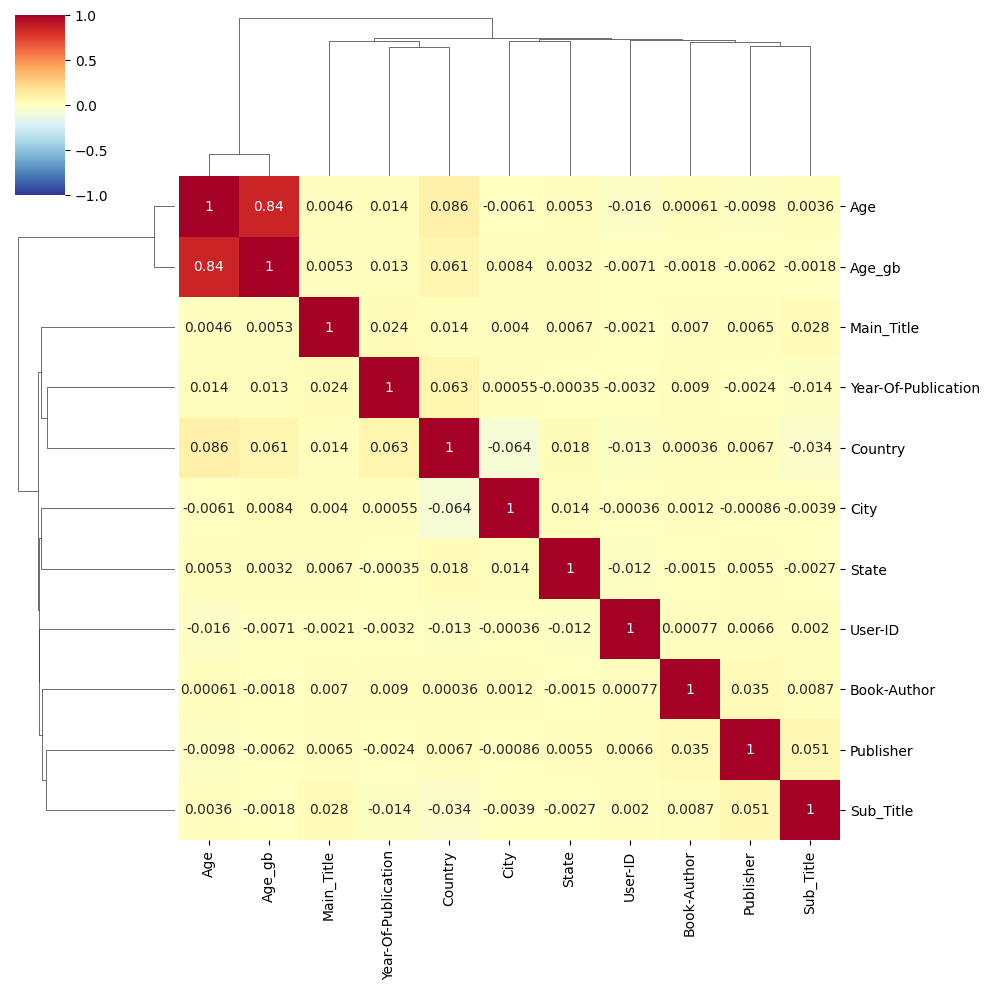

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (7, 7))
clustermap = sns.clustermap(X_train.corr(), cmap = 'RdYlBu_r',vmin = -1, vmax = 1, annot = True)

#모델 학습 (catboostregressor)

In [ ]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

##하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
k = 20 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')

    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)


    print( "\nFold ", i)

    fit_model = model.fit(train_pool,
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )


    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))


        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)

    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)

y_test_pred /= k  # Average test set predictions



In [ ]:
cat_importance_feature = np.argsor(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()